In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

# pd.set_option('display.max_rows', None)

In [2]:
def merge_source_data():
    # Read data and concatenate
    DIRECTORY = '../data/'
    NAMEBASE = 'EPA_OD_'
    DATAYEARS = ['2021', '2022']

    df_pm25 = pd.DataFrame()
    cols = []
    for yr in DATAYEARS:
        for month in range(1, 13):
            month = str(month).zfill(2)
            path = DIRECTORY + NAMEBASE + yr + month + '.csv'
            if not os.path.exists(path):
                break
            df = pd.read_csv(path, low_memory=False)
            if len(cols) == 0:
                cols = df.columns
            assert (cols == df.columns).all(), f'Columns do not match {yr}{month}\n{cols}\n{df.columns}'
            df_pm25 = pd.concat([df_pm25, df], ignore_index=True)

    df_pm25.to_csv(DIRECTORY + 'pm25.csv', index=False)
    return df_pm25

In [3]:
df_pm25 = pd.read_csv('../data/pm25.csv') if os.path.exists('../data/pm25.csv') else merge_source_data()

/tmp/ipykernel_16022/955647487.py:1: DtypeWarning: Columns (6,7,8,9,10,11,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pm25 = pd.read_csv('../data/pm25.csv') if os.path.exists('../data/pm25.csv') else merge_source_data()


In [4]:
region_cols = ['SiteId', 'SiteName', 'County', 'Latitude', 'Longitude']
df_region = df_pm25[region_cols].drop_duplicates().reset_index(drop=True).sort_values(by='SiteId').reset_index(drop=True)
df_region

,SiteId,SiteName,County,Latitude,Longitude
0,0,大城,彰化縣,23.854931,120.269642
1,1,基隆,基隆市,25.129167,121.760056
2,2,汐止,新北市,25.067131,121.642300
3,3,萬里,新北市,25.179667,121.689881
4,4,新店,新北市,24.977222,121.537778
...,...,...,...,...,...
98,312,桃園(竹圍),桃園市,25.103636,121.244261
99,312,臺南(學甲),臺南市,23.236881,120.183397
100,312,永和(環河),新北市,25.012314,121.504103
101,313,屏東(枋寮),屏東縣,22.370947,120.591167


In [5]:
def extract_site_name(siteName):
    regex = r"([^\(\t]*)\((.*)\)"
    match = re.search(regex, siteName)
    if match and match.group(1) == "永和":
        return match.group(1)
    return match.group(2) if match else siteName

In [6]:
def format_site_information():
    if os.path.exists('../data/site_information.csv'):
        return pd.read_csv('../data/site_information.csv')
    df_region_map = df_region.copy()
    # format site name
    df_region_map['SiteName'] = df_region_map['SiteName'].apply(extract_site_name)
    # change SiteId == 0 to 85
    df_region_map.loc[df_region_map['SiteId'] == 0, 'SiteId'] = 85
    df_region_map.drop_duplicates(subset=['SiteName', 'County'], inplace=True)
    df_region_map.sort_values(by='SiteId', inplace=True, ignore_index=True)
    # reset SiteId > 85 to index + 8
    df_region_map.loc[df_region_map['SiteId'] > 85, 'SiteId'] = df_region_map.loc[df_region_map['SiteId'] > 85].index + 8
    df_region_map.to_csv('../data/site_information.csv', index=False)
    return df_region_map

df_region_map = format_site_information()

In [7]:
# map site information to pm25 data
def map_siteId(siteName):
    site_info = df_region_map[df_region_map['SiteName'] == siteName]
    return site_info['SiteId'].values[0] if len(site_info) > 0 else np.nan

df_pm25.SiteName = df_pm25.SiteName.apply(extract_site_name)
df_pm25.SiteId = df_pm25.SiteName.apply(map_siteId)

In [8]:
# Drop unnecessary columns
unnecessary_cols = ['County', 'Latitude', 'Longitude', 'Status']
cols = [col for col in df_pm25.columns if col in unnecessary_cols]
df_pm25.drop(columns=cols, inplace=True)
print("Successfully drop columns:", cols)


Successfully drop columns: ['County', 'Status', 'Longitude', 'Latitude']


In [9]:
# Deal with missing values

# Drop rows with missing pm25 values
df_pm25.dropna(subset=['PM2.5'], inplace=True)
print("After dropna of pm25", df_pm25.shape)

# Fill missing values with UNKNOWN in 'Pollutant'
df_pm25.Pollutant.fillna('UNKNOWN', inplace=True)

# Drop rows with '-' in any columns
row_mask = df_pm25.apply(lambda row: '-' in row.values, axis=1)
df_pm25.drop(df_pm25[row_mask].index, inplace=True)
print("After drop '-' rows:", df_pm25.shape)

# Drop rows with NaN in columns except WindSpeed, WindDirec
cols = ['WindSpeed', 'WindDirec', 'PublishTime']
drop_cols = [col for col in df_pm25.columns if col not in cols]
df_pm25.dropna(subset=drop_cols, inplace=True, how='any')
print("Drop columns:", drop_cols)
print("After drop NaN:", df_pm25.shape)

After dropna of pm25 (2287218, 20)
After drop '-' rows: (2212304, 20)
Drop columns: ['SiteName', 'AQI', 'Pollutant', 'SO2', 'CO', 'CO_8hr', 'O3', 'O3_8hr', 'PM10', 'PM10_AVG', 'PM2.5', 'PM2.5_AVG', 'NO2', 'NOx', 'NO', 'SO2_AVG', 'SiteId']
After drop NaN: (2078244, 20)


In [19]:
# reset column order
cols = ['SiteId', 'SiteName', 'PublishTime', 'AQI', 
        'SO2', 'SO2_AVG', 'CO', 'CO_8hr', 'O3', 'O3_8hr', 'NO2', 'NOx', 'NO',
        'PM10', 'PM10_AVG', 'PM2.5', 'PM2.5_AVG', 
        'WindSpeed', 'WindDirec', 'Pollutant']
df_pm25 = df_pm25[cols]

In [20]:
# set data type
datatype = {
    'SiteId': np.dtype('int'), 
    'SiteName': np.dtype('O'),
    'PublishTime': np.dtype('O'),
    'AQI': np.dtype('float'),
    'SO2': np.dtype('float'),
    'SO2_AVG': np.dtype('float'),
    'CO': np.dtype('float'),
    'CO_8hr': np.dtype('float'),
    'O3': np.dtype('float'),
    'O3_8hr': np.dtype('float'),
    'NO2': np.dtype('float'),
    'NOx': np.dtype('float'),
    'NO': np.dtype('float'),
    'PM10': np.dtype('float'),
    'PM10_AVG': np.dtype('float'),
    'PM2.5': np.dtype('float'),
    'PM2.5_AVG': np.dtype('float'),
    'WindSpeed': np.dtype('float'),
    'WindDirec': np.dtype('float'),
    'Pollutant': np.dtype('O')
}

df_pm25 = df_pm25.astype(datatype)

In [21]:
df_pm25.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2078244 entries, 0 to 2332441
Data columns (total 20 columns):
 #   Column       Dtype  
---  ------       -----  
 0   SiteId       int64  
 1   SiteName     object 
 2   PublishTime  object 
 3   AQI          float64
 4   SO2          float64
 5   SO2_AVG      float64
 6   CO           float64
 7   CO_8hr       float64
 8   O3           float64
 9   O3_8hr       float64
 10  NO2          float64
 11  NOx          float64
 12  NO           float64
 13  PM10         float64
 14  PM10_AVG     float64
 15  PM2.5        float64
 16  PM2.5_AVG    float64
 17  WindSpeed    float64
 18  WindDirec    float64
 19  Pollutant    object 
dtypes: float64(16), int64(1), object(3)
memory usage: 333.0+ MB


In [12]:
df_pm25.to_csv('../data/pm25_processed.csv', index=False)

In [22]:
# change Pollutant column to one-hot encoding
label_mapping = {
    '細懸浮微粒': 'PM2.5',
    '臭氧八小時': 'O3_8hr',
    '懸浮微粒': 'PM10',
    '二氧化硫': 'SO2',
    '二氧化氮': 'NO2',
    '臭氧': 'O3',
    '一氧化碳': 'CO'
}
df_pm25.Pollutant = df_pm25.Pollutant.replace(label_mapping)
df_pm25_coefficient = pd.get_dummies(df_pm25, columns=['Pollutant'])
df_pm25_coefficient.drop(columns=['SiteId', 'SiteName', 'PublishTime', 'WindSpeed', 'WindDirec'], inplace=True)

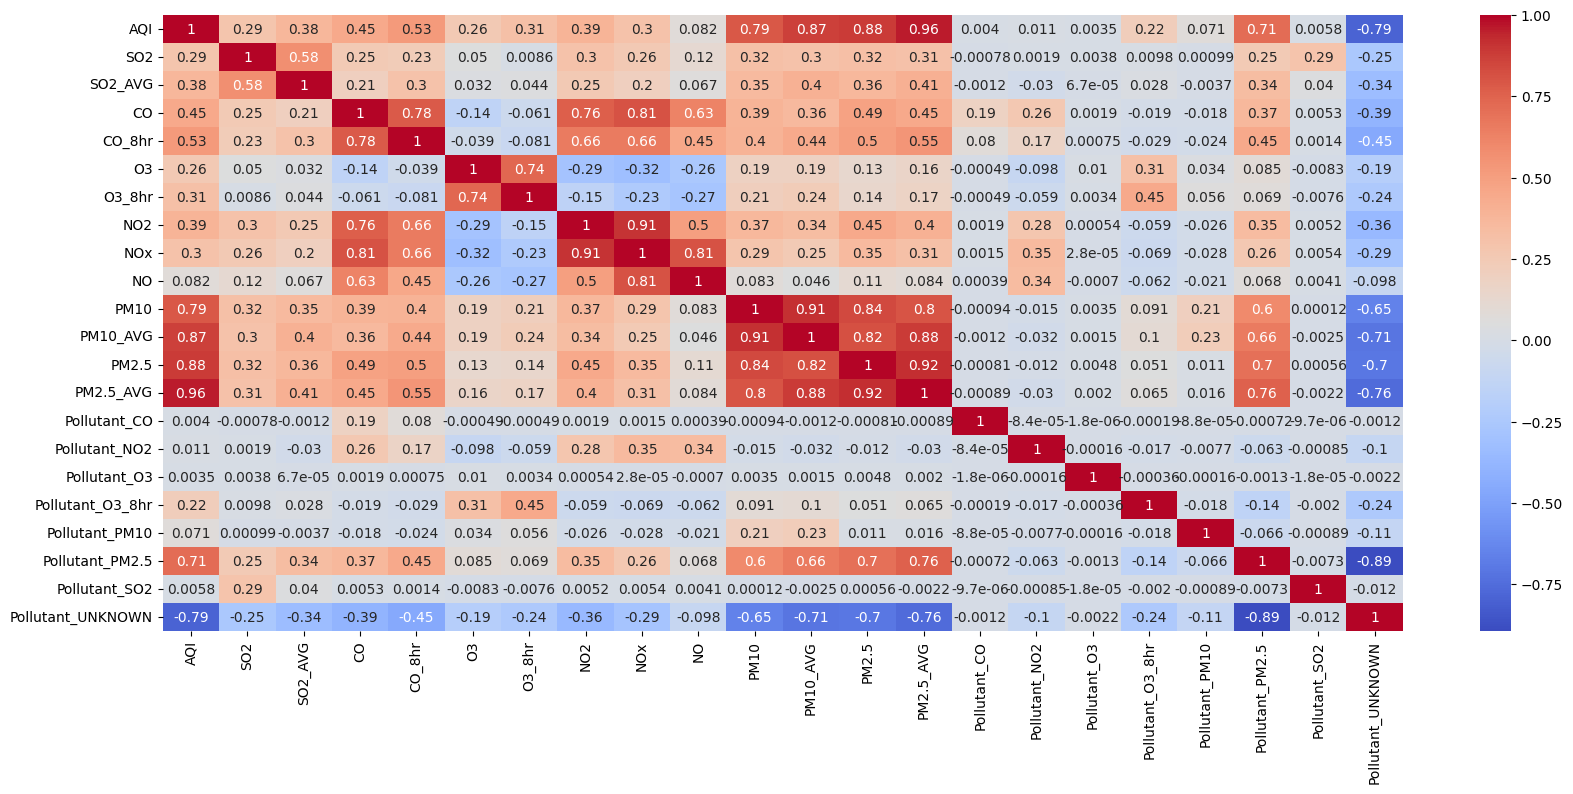

<Figure size 640x480 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot coefficient relationship heatmap
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(df_pm25_coefficient.corr(), annot=True, ax=ax, cmap='coolwarm')
plt.savefig('../images/heatmap.png')
plt.show()